### The objective of this project is to detect whether each text from reddit contains suicidial intent by applying languages model BERT.


#### Import Libraries

In [1]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 50.2 MB/s eta 0:00:00


In [3]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
import keras
from tqdm import tqdm
import pickle
from keras.models import Model
import keras.backend as K
from sklearn import metrics
from sklearn.metrics import confusion_matrix,f1_score,classification_report
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
import itertools
from keras.models import load_model
from sklearn.utils import shuffle
from transformers import *
from transformers import BertTokenizer, TFBertModel, BertConfig
from wordcloud import WordCloud
!pip install neattext
import neattext.functions as nfx
import matplotlib.pyplot as plt
import plotly.express as plx
from tqdm import tqdm
import seaborn as sns
from keras.layers import Embedding,Dense,LSTM,Bidirectional,GlobalMaxPooling1D,Input,Dropout
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_flax_utils.py:24: FutureWarning: Importing `FlaxGenerationMixin` from `src/transformers/generation_flax_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import FlaxGenerationMixin` instead.
  warnings.warn(
Xformers is not installed correctly. If you want to use memorry_efficient_attenti

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 3.8 MB/s eta 0:00:00


#### Read in data

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
path = '/content/gdrive/MyDrive/Colab Notebooks/ML/Final_Project/'

In [6]:
data=pd.read_csv(path + 'Suicide_Detection.csv' ,encoding='ISO-8859-1')
data.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"Iâm so lostHello, my name is Adam (16) and I...",suicide


#### Data Preprocessing

In [7]:
data= data.drop('Unnamed: 0',axis=1)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232074 entries, 0 to 232073
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    232074 non-null  object
 1   class   232074 non-null  object
dtypes: object(2)
memory usage: 3.5+ MB


In [9]:
print('File has {} rows and {} columns'.format(data.shape[0],data.shape[1]))

File has 232074 rows and 2 columns


In [10]:
class_counts = data['class'].value_counts()
class_counts

suicide        116037
non-suicide    116037
Name: class, dtype: int64

#### EDA
- check if the data is balanced.

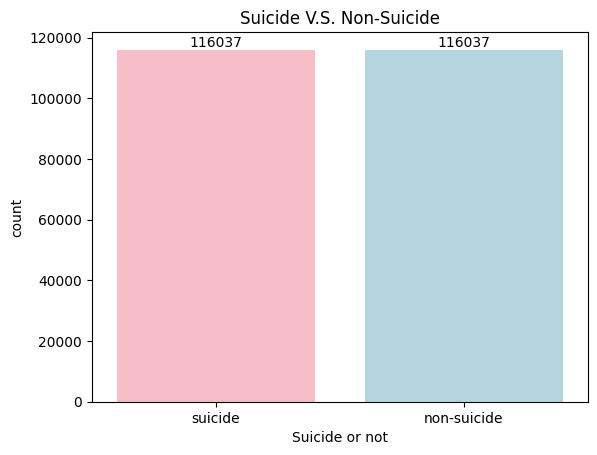

In [11]:
# create a bar plot
bar_colors = ['lightpink', 'lightblue']
ax = sns.barplot(x=class_counts.index, y=class_counts.values, palette=bar_colors)
plt.xlabel('Suicide or not')
plt.ylabel('count')
plt.title('Suicide V.S. Non-Suicide')

# Add label numbers on top of each bar
for i, v in enumerate(class_counts.values):
    ax.text(i, v, str(v), ha='center', va='bottom')

# Display the plot
plt.show()

From above, we can see that suicide and non-suicide messages have the same amount. The dataset is balanced. There is no need to utilize techniques to balance the data.

#### Feature Engineering: message length

In [12]:
data['message_len'] = data['text'].apply(lambda x: len(x.split(' ')))
data.head()

,text,class,message_len
0,Ex Wife Threatening SuicideRecently I left my ...,suicide,143
1,Am I weird I don't get affected by compliments...,non-suicide,27
2,Finally 2020 is almost over... So I can never ...,non-suicide,26
3,i need helpjust help me im crying so hard,suicide,9
4,"Iâm so lostHello, my name is Adam (16) and I...",suicide,436


In [13]:
max(data['message_len'])

15632

In [14]:
data['label'] = data['class'].map({'non-suicide':0,'suicide':1})
data.head()

,text,class,message_len,label
0,Ex Wife Threatening SuicideRecently I left my ...,suicide,143,1
1,Am I weird I don't get affected by compliments...,non-suicide,27,0
2,Finally 2020 is almost over... So I can never ...,non-suicide,26,0
3,i need helpjust help me im crying so hard,suicide,9,1
4,"Iâm so lostHello, my name is Adam (16) and I...",suicide,436,1


In [15]:
data.isna().sum()

text           0
class          0
message_len    0
label          0
dtype: int64

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232074 entries, 0 to 232073
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   text         232074 non-null  object
 1   class        232074 non-null  object
 2   message_len  232074 non-null  int64 
 3   label        232074 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 7.1+ MB


In [17]:
suicide_df = data[data['class'] == 'suicide']
non_suicide_df = data[data['class'] == 'non-suicide']

In [18]:
suicide_df.describe()

,message_len,label
count,116037.000000,116037.0
mean,202.162664,1.0
std,254.581926,0.0
min,1.000000,1.0
25%,60.000000,1.0
50%,127.000000,1.0
75%,250.000000,1.0
max,9684.000000,1.0


In [19]:
non_suicide_df.describe()

,message_len,label
count,116037.000000,116037.0
mean,60.930212,0.0
std,154.452377,0.0
min,2.000000,0.0
25%,18.000000,0.0
50%,31.000000,0.0
75%,60.000000,0.0
max,15632.000000,0.0


#### Plot Message Length Distribution By Class (Suicide V.S. Non-Suicide)

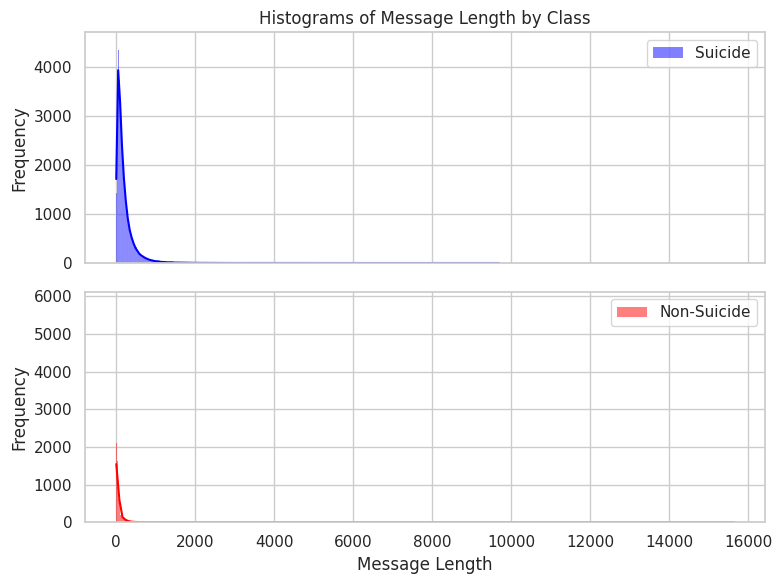

In [20]:
suicide_df = data[data['class'] == 'suicide']
non_suicide_df = data[data['class'] == 'non-suicide']
# Set plot style
sns.set(style='whitegrid')

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# Plot histogram for Class 1: suicide
sns.histplot(suicide_df['message_len'], ax=axs[0], kde=True, color='blue', label='Suicide')

# Plot histogram for Class 2: non-suicide
sns.histplot(non_suicide_df['message_len'], ax=axs[1], kde=True, color='red', label='Non-Suicide')

# Set plot labels and titles
axs[0].set_ylabel('Frequency')
axs[1].set_ylabel('Frequency')
axs[1].set_xlabel('Message Length')
axs[0].set_title('Histograms of Message Length by Class')

# Add legend
axs[0].legend()
axs[1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


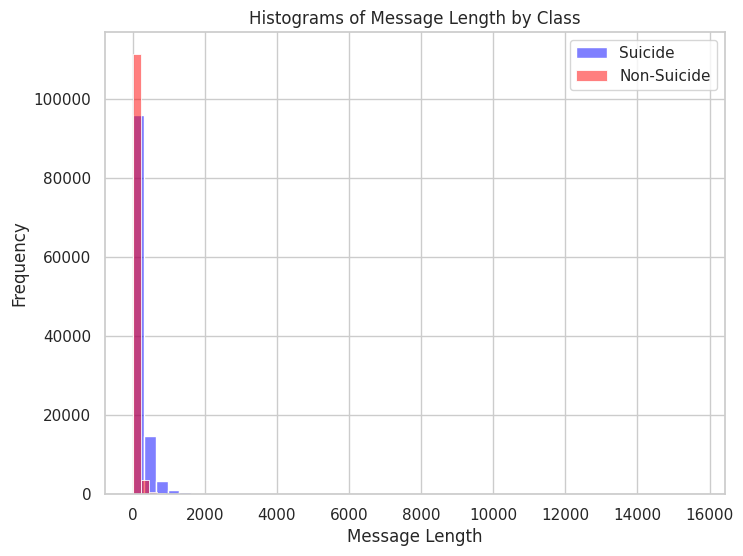

In [21]:
# Adjust bin width approach
plt.figure(figsize=(8, 6))
sns.histplot(suicide_df['message_len'], bins=30, color='blue', alpha=0.5, label='Suicide')
sns.histplot(non_suicide_df['message_len'], bins=70, color='red', alpha=0.5, label='Non-Suicide')
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.title('Histograms of Message Length by Class')
plt.legend()
plt.show()

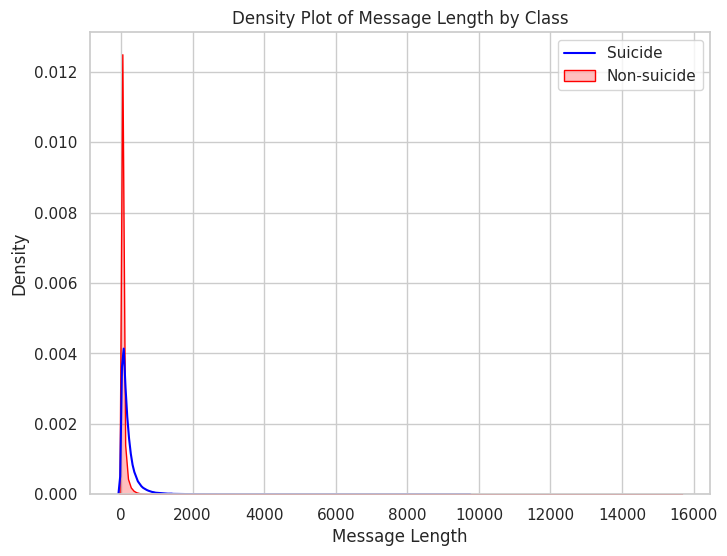

In [22]:
# Density plot approach
# Density plot with filled area
plt.figure(figsize=(8, 6))
sns.kdeplot(suicide_df['message_len'], color='blue', label='Suicide')
sns.kdeplot(non_suicide_df['message_len'], color='red', label='Non-suicide', fill=True)  # Filled area for Class 2
plt.xlabel('Message Length')
plt.ylabel('Density')
plt.title('Density Plot of Message Length by Class')
plt.legend()
plt.show()

#### Data Cleaning & Feature Engineering
- remove stopwords, numbers, punctuations in the message and create another column called "clean_text"
- create another column "text length" based on clean_text

In [23]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def clean_stopwords_shortwords(w):
    stopwords_list=stopwords.words('english')
    words = w.split() 
    clean_words = [word for word in words if (word not in stopwords_list) and len(word) > 2]
    return " ".join(clean_words) 

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    w = re.sub(r"([?.!,¿])", r" ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w=clean_stopwords_shortwords(w)
    w=re.sub(r'@\w+', '',w)
    return w

In [24]:
data=data.reset_index()                                             
data = shuffle(data)                                                         # Shuffle the dataset
print('Available labels: ',data.label.unique())                              # Print all the unique labels in the dataset
data['clean_text']=data['text'].map(preprocess_sentence)   
data.head()

Available labels:  [0 1]


,index,text,class,message_len,label,clean_text
70695,70695,"Yeah, I Get Girls all the Time Dude G - Gettin...",non-suicide,22,0,yeah get girls time dude getting ignored rejec...
122626,122626,"sorry guys, i failed i asked her if she likes ...",non-suicide,21,0,sorry guys failed asked likes said ita terribl...
41829,41829,Get stick bugged lmao This subreddit has basic...,non-suicide,12,0,get stick bugged lmao subreddit basically turn...
155635,155635,HelpIn a toxic relationship. Beg for her not t...,suicide,257,1,helpin toxic relationship beg leave threatens ...
89359,89359,I decided to delay my suicide attemptI got som...,suicide,72,1,decided delay suicide attempti got clothes ord...


In [25]:
data['text'][122350]

'so that it canâ\x80\x99t get any worseat this point i want to do it just so I know iâ\x80\x99ve already gone through the worst. I donâ\x80\x99t consider myself to have â\x80\x9csurvived it this long, so why not keep goingâ\x80\x9d because i donâ\x80\x99t want to know how bad it can get. iâ\x80\x99d like to say i have a pretty strong threshold for bullshit but i really donâ\x80\x99t want to test myself anymore'

In [26]:
data['clean_text'][122350]

'cana get worseat point want know already gone worst dona consider survived long keep goinga dona want know bad get like say pretty strong threshold bullshit really dona want test anymore'

In [27]:
data['clean_text_len'] = data['clean_text'].apply(lambda x: len(x.split(' ')))
data.head()

,index,text,class,message_len,label,clean_text,clean_text_len
70695,70695,"Yeah, I Get Girls all the Time Dude G - Gettin...",non-suicide,22,0,yeah get girls time dude getting ignored rejec...,13
122626,122626,"sorry guys, i failed i asked her if she likes ...",non-suicide,21,0,sorry guys failed asked likes said ita terribl...,10
41829,41829,Get stick bugged lmao This subreddit has basic...,non-suicide,12,0,get stick bugged lmao subreddit basically turn...,8
155635,155635,HelpIn a toxic relationship. Beg for her not t...,suicide,257,1,helpin toxic relationship beg leave threatens ...,103
89359,89359,I decided to delay my suicide attemptI got som...,suicide,72,1,decided delay suicide attempti got clothes ord...,33


In [28]:
max(data['clean_text_len'])

5850

In [29]:
suicide_df = data[data['class'] == 'suicide']
non_suicide_df = data[data['class'] == 'non-suicide']

In [30]:
suicide_df.describe()

,index,message_len,label,clean_text_len
count,116037.000000,116037.000000,116037.0,116037.000000
mean,116086.046554,202.162664,1.0,90.045942
std,66927.797671,254.581926,0.0,112.414673
min,0.000000,1.000000,1.0,1.000000
25%,58158.000000,60.000000,1.0,27.000000
50%,115927.000000,127.000000,1.0,57.000000
75%,174162.000000,250.000000,1.0,111.000000
max,232072.000000,9684.000000,1.0,3874.000000


In [31]:
non_suicide_df.describe()

,index,message_len,label,clean_text_len
count,116037.000000,116037.000000,116037.0,116037.000000
mean,115986.953446,60.930212,0.0,29.110223
std,67060.663534,154.452377,0.0,73.191506
min,1.000000,2.000000,0.0,1.000000
25%,57875.000000,18.000000,0.0,9.000000
50%,116157.000000,31.000000,0.0,16.000000
75%,173940.000000,60.000000,0.0,29.000000
max,232073.000000,15632.000000,0.0,5850.000000


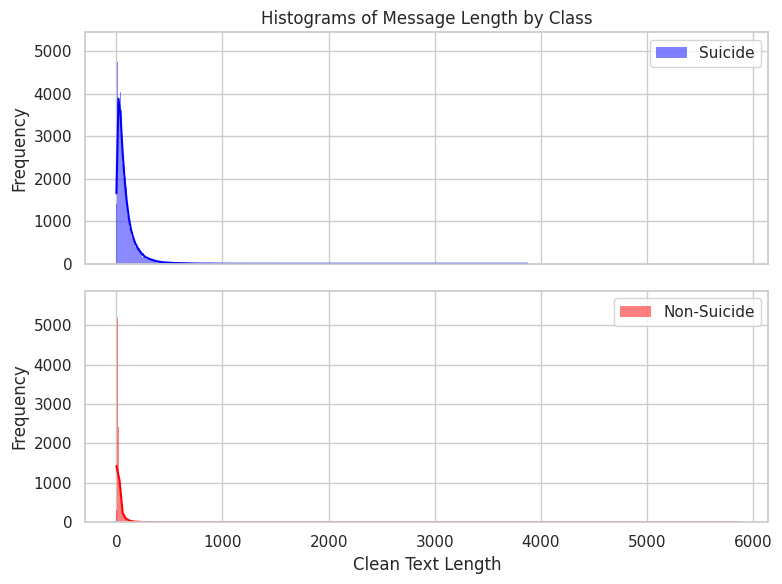

In [32]:
# Set plot style
sns.set(style='whitegrid')

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# Plot histogram for Class 1: suicide
sns.histplot(suicide_df['clean_text_len'], ax=axs[0], kde=True, color='blue', label='Suicide')

# Plot histogram for Class 2: non-suicide
sns.histplot(non_suicide_df['clean_text_len'], ax=axs[1], kde=True, color='red', label='Non-Suicide')

# Set plot labels and titles
axs[0].set_ylabel('Frequency')
axs[1].set_ylabel('Frequency')
axs[1].set_xlabel('Clean Text Length')
axs[0].set_title('Histograms of Message Length by Class')

# Add legend
axs[0].legend()
axs[1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

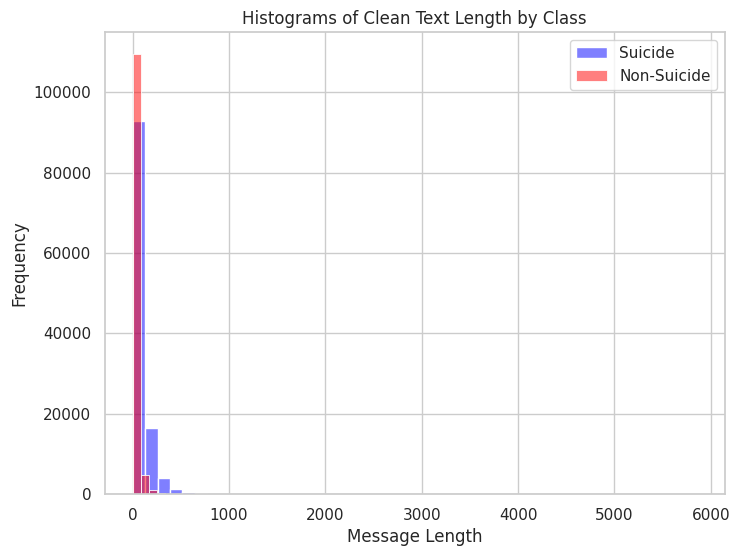

In [33]:
# Adjust bin width approach
plt.figure(figsize=(8, 6))
sns.histplot(suicide_df['clean_text_len'], bins=30, color='blue', alpha=0.5, label='Suicide')
sns.histplot(non_suicide_df['clean_text_len'], bins=70, color='red', alpha=0.5, label='Non-Suicide')
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.title('Histograms of Clean Text Length by Class')
plt.legend()
plt.show()

#### Tokens visualization 
- Show the most frequent words in suicide messages & non-suicide messages

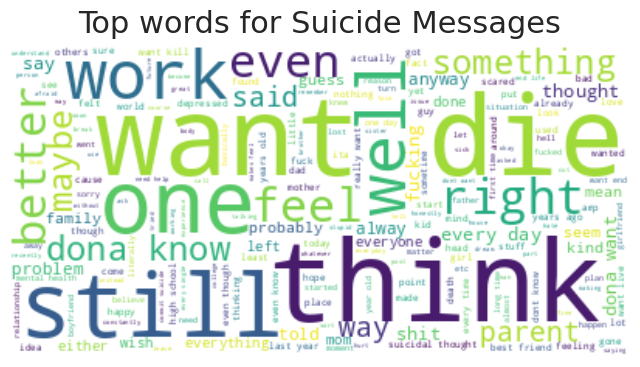

In [34]:
# Filter the data for suicide class
suicide_texts = data.loc[data['class'] == 'suicide', 'clean_text']

# Generate WordCloud
wc = WordCloud(
    background_color='white',
    max_words=200
)
wc.generate(' '.join(text for text in suicide_texts))

# Plot the WordCloud
plt.figure(figsize=(8, 6))
plt.title('Top words for Suicide Messages', fontdict={'size': 22, 'verticalalignment': 'bottom'})
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

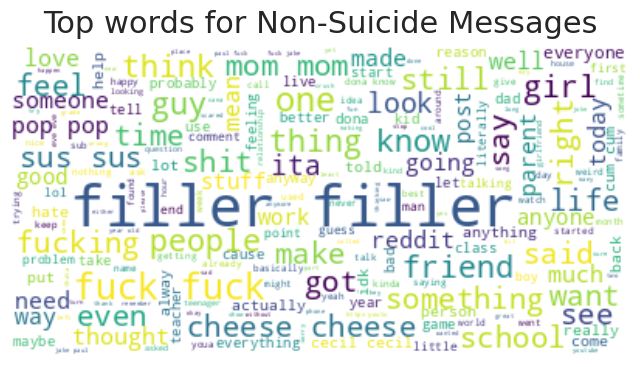

In [35]:
# Filter the data for non-suicide class
non_suicide_texts = data.loc[data['class'] == 'non-suicide', 'clean_text']

# Generate WordCloud
wc = WordCloud(
    background_color='white',
    max_words=200
)
wc.generate(' '.join(text for text in non_suicide_texts))

# Plot the WordCloud
plt.figure(figsize=(8, 6))
plt.title('Top words for Non-Suicide Messages', fontdict={'size': 22, 'verticalalignment': 'bottom'})
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### Model Building

#### Setting up a pre-trained BERT model for fine-tuning

In [36]:
num_classes=len(data.label.unique())
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=num_classes)

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/tokenizer_config.json


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.29.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.js

loading weights file tf_model.h5 from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/tf_model.h5
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
sent= 'how to train the model, lets look at how a trained model calculates its prediction.'
tokens=bert_tokenizer.tokenize(sent)
print(tokens)

['how', 'to', 'train', 'the', 'model', ',', 'lets', 'look', 'at', 'how', 'a', 'trained', 'model', 'calculate', '##s', 'its', 'prediction', '.']


In [38]:
tokenized_sequence= bert_tokenizer.encode_plus(sent,add_special_tokens = True,max_length = 200,pad_to_max_length = True,
return_attention_mask = True)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [39]:
bert_tokenizer.decode(tokenized_sequence['input_ids'])

'[CLS] how to train the model, lets look at how a trained model calculates its prediction. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

In [40]:
data.head()

,index,text,class,message_len,label,clean_text,clean_text_len
70695,70695,"Yeah, I Get Girls all the Time Dude G - Gettin...",non-suicide,22,0,yeah get girls time dude getting ignored rejec...,13
122626,122626,"sorry guys, i failed i asked her if she likes ...",non-suicide,21,0,sorry guys failed asked likes said ita terribl...,10
41829,41829,Get stick bugged lmao This subreddit has basic...,non-suicide,12,0,get stick bugged lmao subreddit basically turn...,8
155635,155635,HelpIn a toxic relationship. Beg for her not t...,suicide,257,1,helpin toxic relationship beg leave threatens ...,103
89359,89359,I decided to delay my suicide attemptI got som...,suicide,72,1,decided delay suicide attempti got clothes ord...,33


In [41]:
sentences=data['clean_text']
labels=data['label']
len(sentences),len(labels)

(232074, 232074)

In [42]:
input_ids=[]
attention_masks=[]

for sent in sentences:
    bert_inp=bert_tokenizer.encode_plus(sent,add_special_tokens = True,max_length = 64,pad_to_max_length = True,return_attention_mask = True)
    input_ids.append(bert_inp['input_ids'])
    attention_masks.append(bert_inp['attention_mask'])

input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)
labels=np.array(labels)

In [43]:
len(input_ids),len(attention_masks),len(labels)

(232074, 232074, 232074)

In [44]:
print('Preparing the pickle file.....')

pickle_inp_path='/content/gdrive/MyDrive/Colab Notebooks/ML/Final_Project/bert_sui_inp.pkl'
pickle_mask_path='/content/gdrive/MyDrive/Colab Notebooks/ML/Final_Project/bert_sui_mask.pkl'
pickle_label_path='/content/gdrive/MyDrive/Colab Notebooks/ML/Final_Project/bert_sui_label.pkl'

pickle.dump((input_ids),open(pickle_inp_path,'wb'))
pickle.dump((attention_masks),open(pickle_mask_path,'wb'))
pickle.dump((labels),open(pickle_label_path,'wb'))


print('Input shape {} Attention mask shape {} Input label shape {}'.format(input_ids.shape,attention_masks.shape,labels.shape))

Preparing the pickle file.....
Input shape (232074, 64) Attention mask shape (232074, 64) Input label shape (232074,)


#### Split the data into training data(80%), testing data (20%) set

In [45]:
train_inp, test_inp,train_label,test_label,train_mask,test_mask=train_test_split(input_ids,labels,attention_masks,test_size=0.2)
print('Train inp shape {} Test input shape {}\nTrain label shape {} Test label shape {}\nTrain attention mask shape {} Test attention mask shape {}'.format(train_inp.shape,test_inp.shape,train_label.shape,test_label.shape,train_mask.shape,test_mask.shape))

Train inp shape (185659, 64) Test input shape (46415, 64)
Train label shape (185659,) Test label shape (46415,)
Train attention mask shape (185659, 64) Test attention mask shape (46415, 64)


In [46]:
log_dir='tensorboard_data/tb_bert'
model_save_path='/content/gdrive/MyDrive/Colab Notebooks/ML/Final_Project/models/bert_model2.h5'

callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path,save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True),keras.callbacks.TensorBoard(log_dir=log_dir)]

print('\nBert Model',bert_model.summary())


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________

Bert Model None


### Fine Tune BERT model

#### Train the data with batch size = 32, epochs = 1

In [48]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-08)

bert_model.compile(loss=loss,optimizer=optimizer,metrics=[metric])

In [50]:
history=bert_model.fit([train_inp,train_mask],train_label,batch_size=32,epochs=1, validation_split=0.25 , callbacks=callbacks)

4352/4352 [==============================] - 2099s 470ms/step - loss: 0.1413 - accuracy: 0.9470 - val_loss: 0.1141 - val_accuracy: 0.9577


In [51]:
#history=bert_model.fit([train_inp,train_mask],train_label,batch_size=32,epochs=5, validation_split=0.25 , callbacks=callbacks)

In [54]:
model_save_path='/content/gdrive/MyDrive/Colab Notebooks/ML/Final_Project/models/bert_model2.h5'

trained_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=2)
trained_model.compile(loss=loss,optimizer=optimizer, metrics=[metric])
trained_model.load_weights(model_save_path)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.29.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file tf_model.h5 from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/tf_model.h5
All model checkpoint layers were used when 

### Model Prediction

In [55]:
preds = trained_model.predict([test_inp,test_mask],batch_size=32)
preds

1451/1451 [==============================] - 222s 148ms/step


TFSequenceClassifierOutput(loss=None, logits=array([[ 2.68253   , -2.9693208 ],
       [-2.3988013 ,  2.9505923 ],
       [ 3.2385862 , -3.7570727 ],
       ...,
       [-3.3249726 ,  3.938633  ],
       [-0.20389259,  0.23232551],
       [-1.8520125 ,  1.9427505 ]], dtype=float32), hidden_states=None, attentions=None)

In [56]:
logits = preds.logits
probas = np.exp(logits) / np.sum(np.exp(logits), axis=-1, keepdims=True)
pred_labels = np.argmax(probas, axis=-1)
pred_labels 

array([0, 1, 0, ..., 1, 1, 1])

### Model Evaluation

In [57]:
f1 = f1_score(test_label,pred_labels)
print('F1 score',f1)
print('Classification Report')
print(classification_report(test_label,pred_labels))

print('Training and saving built model.....')   

F1 score 0.9582502412351238
Classification Report
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     23394
           1       0.95      0.97      0.96     23021

    accuracy                           0.96     46415
   macro avg       0.96      0.96      0.96     46415
weighted avg       0.96      0.96      0.96     46415

Training and saving built model.....


In [58]:
# Accuracy score
print('\nTest accuracy = ', metrics.accuracy_score(test_label, pred_labels))

# Confusion matrix

cm = confusion_matrix(test_label,pred_labels) 
print ("\nConfusion Matrix : \n", cm) 



Test accuracy =  0.9580523537649467

Confusion Matrix : 
 [[22124  1270]
 [  677 22344]]


<Axes: >

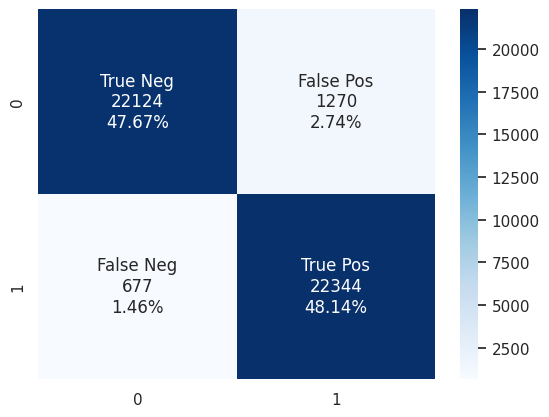

In [59]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
label = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
label = np.asarray(label).reshape(2,2)
sns.heatmap(cm, annot=label, fmt='', cmap='Blues')

In [60]:
test_data = [test_inp, test_mask]

trained_model.evaluate(test_data, test_label, batch_size=32)

1451/1451 [==============================] - 214s 145ms/step - loss: 0.1134 - accuracy: 0.9579


[0.11336158215999603, 0.9578584432601929]

In [88]:
test_inp[:-1]

array([[  101, 23653, 20877, ...,     0,     0,     0],
       [  101,  2439,  7149, ...,  2135,  2081,   102],
       [  101,  3160,  3124, ...,     0,     0,     0],
       ...,
       [  101,  6905,  2869, ...,  2015,  2579,   102],
       [  101,  2215,  2203, ...,  2152, 13002,   102],
       [  101,  2228,  7577, ...,     0,     0,     0]])

- Plot accuracy and loss over time

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


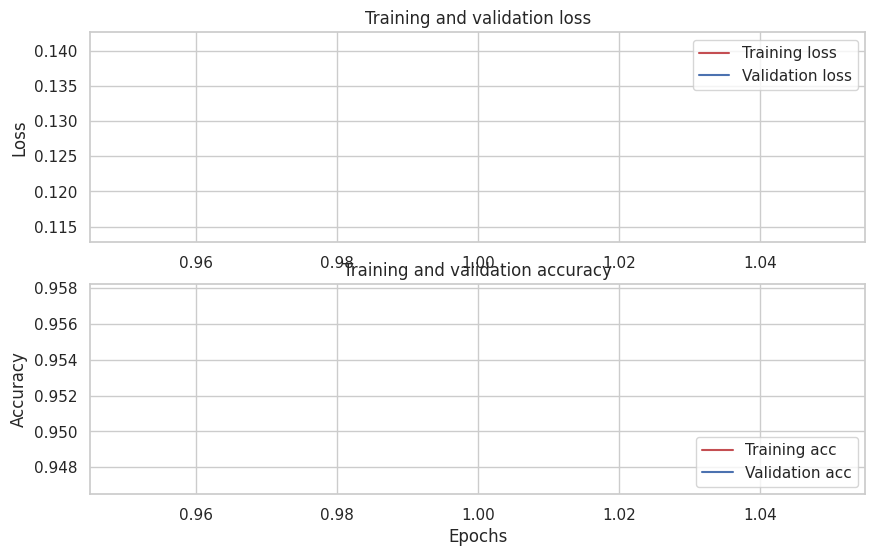

In [74]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

#### Test the result using new text

- case 1

In [104]:
text = ["Today I felt good in the morning, everything was good, but in the evening, it rained, and as a result, I got stuck in traffic. My life sucks; I should end it; I should kill myself.",
        "Today, I felt good in the morning; everything was good, but in the evening, it rained, and as a result, I got stuck in traffic."]

input_ids2 = []
attention_masks2 = []

for t in text:
    bert_inp = bert_tokenizer.encode_plus(t, add_special_tokens=True, max_length=64, pad_to_max_length=True, return_attention_mask=True)
    input_ids2.append(bert_inp['input_ids'])
    attention_masks2.append(bert_inp['attention_mask'])

input_ids2 = np.asarray(input_ids2)
attention_masks2 = np.asarray(attention_masks2)

text_data = [(input_ids2, attention_masks2)]

predictions = trained_model.predict(text_data)

1/1 [==============================] - 0s 87ms/step


In [105]:
predictions

TFSequenceClassifierOutput(loss=None, logits=array([[-0.57476884,  0.42338112],
       [ 1.0067402 , -0.8365319 ]], dtype=float32), hidden_states=None, attentions=None)

In [106]:
logits = predictions.logits
probas_ = np.exp(logits) / np.sum(np.exp(logits), axis=1, keepdims=True)
preditions_labels = np.argmax(probas_, axis=-1)
preditions_labels

array([1, 0])

- case 2

In [113]:
text = ["I went for a walk in the park today and enjoyed the beautiful weather. It was so refreshing to be surrounded by nature and feel the sunshine on my face. I even saw some ducks swimming in the pond. It was a wonderful day.",
        "Lately, life has become unbearable. Every day feels like a struggle, and I can't find any joy or purpose. The weight of sadness and despair is crushing me, and I can't see any way out. It feels like the world would be better off without me. The pain inside me is overwhelming."]

input_ids2 = []
attention_masks2 = []

for t in text:
    bert_inp = bert_tokenizer.encode_plus(t, add_special_tokens=True, max_length=64, pad_to_max_length=True, return_attention_mask=True)
    input_ids2.append(bert_inp['input_ids'])
    attention_masks2.append(bert_inp['attention_mask'])

input_ids2 = np.asarray(input_ids2)
attention_masks2 = np.asarray(attention_masks2)

text_data = [(input_ids2, attention_masks2)]

predictions = trained_model.predict(text_data)

1/1 [==============================] - 0s 123ms/step


In [114]:
predictions

TFSequenceClassifierOutput(loss=None, logits=array([[ 1.5167788 , -1.441735  ],
       [-1.0251466 ,  0.81894416]], dtype=float32), hidden_states=None, attentions=None)

In [115]:
logits = predictions.logits
probas_ = np.exp(logits) / np.sum(np.exp(logits), axis=1, keepdims=True)
preditions_labels = np.argmax(probas_, axis=-1)
preditions_labels

array([0, 1])

### Fine Tune Bert model

In [61]:
bert_model2 = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=num_classes)

#train_inp, test_inp,train_label,test_label,train_mask,test_mask=train_test_split(input_ids,labels,attention_masks,test_size=0.2)

train2_inp, test2_inp,train2_label,test2_label,train2_mask,test2_mask=train_test_split(input_ids,labels,attention_masks,test_size=0.2)
print('Train inp shape {} Test input shape {}\nTrain label shape {} Test label shape {}\nTrain attention mask shape {} Test attention mask shape {}'.format(train_inp.shape,test_inp.shape,train_label.shape,test_label.shape,train_mask.shape,test_mask.shape))

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.29.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file tf_model.h5 from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/tf_model.h5
All model checkpoint layers were used when 

Train inp shape (185659, 64) Test input shape (46415, 64)
Train label shape (185659,) Test label shape (46415,)
Train attention mask shape (185659, 64) Test attention mask shape (46415, 64)


In [62]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
adamw = tf.keras.optimizers.experimental.AdamW(learning_rate = 2e-5, weight_decay=0.01)
bert_mode2 = bert_model2.compile(loss=loss,optimizer=adamw,metrics=[metric])

In [63]:
log_dir='tensorboard_data/tb_bert'
model_save_path='/content/gdrive/MyDrive/Colab Notebooks/ML/Final_Project/models/bert_model3.h5'

callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path,save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True),keras.callbacks.TensorBoard(log_dir=log_dir)]

print('\nBert Model2',bert_model2.summary())

Model: "tf_bert_for_sequence_classification_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_113 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________

Bert Model2 None


In [64]:
history2=bert_model2.fit([train2_inp,train2_mask],train2_label,batch_size=32,epochs=5, validation_split=0.25 , callbacks=callbacks)

Epoch 1/5
4352/4352 [==============================] - 2190s 486ms/step - loss: 0.1406 - accuracy: 0.9468 - val_loss: 0.1135 - val_accuracy: 0.9576
Epoch 2/5
4352/4352 [==============================] - 2024s 465ms/step - loss: 0.0847 - accuracy: 0.9693 - val_loss: 0.1309 - val_accuracy: 0.9554
Epoch 3/5
4352/4352 [==============================] - 2016s 463ms/step - loss: 0.0497 - accuracy: 0.9826 - val_loss: 0.1230 - val_accuracy: 0.9593
Epoch 4/5
4352/4352 [==============================] - 2074s 476ms/step - loss: 0.0300 - accuracy: 0.9896 - val_loss: 0.1507 - val_accuracy: 0.9545
Epoch 5/5
4352/4352 [==============================] - 2029s 466ms/step - loss: 0.0207 - accuracy: 0.9929 - val_loss: 0.1607 - val_accuracy: 0.9569


In [65]:
model_save_path='/content/gdrive/MyDrive/Colab Notebooks/ML/Final_Project/models/bert_model3.h5'

trained_model2 = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=2)
trained_model2.compile(loss=loss,optimizer=adamw, metrics=[metric])
trained_model2.load_weights(model_save_path)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.29.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file tf_model.h5 from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/tf_model.h5
All model checkpoint layers were used when 

#### Model Prediction

In [66]:
preds2 = trained_model2.predict([test2_inp,test2_mask],batch_size=32)
preds2

1451/1451 [==============================] - 212s 143ms/step


TFSequenceClassifierOutput(loss=None, logits=array([[-4.422692  ,  3.6359088 ],
       [ 3.3560834 , -2.5906096 ],
       [ 2.9571958 , -1.9733511 ],
       ...,
       [ 1.3816804 , -0.62191945],
       [-1.2602818 ,  1.6242292 ],
       [-1.035557  ,  1.4004134 ]], dtype=float32), hidden_states=None, attentions=None)

In [67]:
logits = preds2.logits
probas2 = np.exp(logits) / np.sum(np.exp(logits), axis=-1, keepdims=True)
pred2_labels = np.argmax(probas, axis=-1)
pred2_labels 

array([0, 1, 0, ..., 1, 1, 1])

#### Model Evaluation

In [68]:
f1 = f1_score(test2_label,pred2_labels)
print('F1 score',f1)
print('Classification Report')
print(classification_report(test2_label,pred2_labels))

print('Training and saving built model.....')   

F1 score 0.5030522945570971
Classification Report
              precision    recall  f1-score   support

           0       0.50      0.49      0.49     23179
           1       0.50      0.51      0.50     23236

    accuracy                           0.50     46415
   macro avg       0.50      0.50      0.50     46415
weighted avg       0.50      0.50      0.50     46415

Training and saving built model.....


In [69]:
# Accuracy score
print('\nTest accuracy = ', metrics.accuracy_score(test2_label, pred2_labels))

# Confusion matrix

cm = confusion_matrix(test2_label,pred2_labels) 
print ("\nConfusion Matrix : \n", cm) 



Test accuracy =  0.49839491543682

Confusion Matrix : 
 [[11349 11830]
 [11452 11784]]


<Axes: >

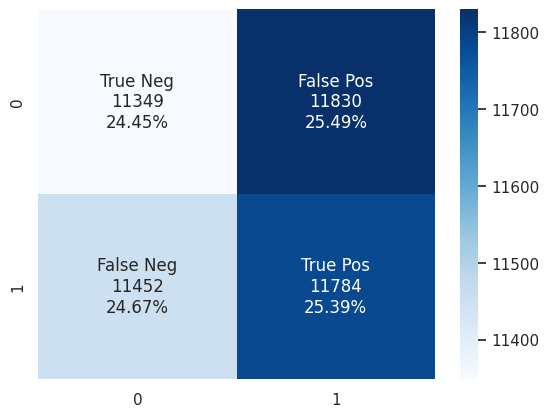

In [70]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
label = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
label = np.asarray(label).reshape(2,2)
sns.heatmap(cm, annot=label, fmt='', cmap='Blues')

In [72]:
test2_data = [test2_inp, test2_mask]

trained_model2.evaluate(test2_data, test2_label, batch_size=32)

1451/1451 [==============================] - 216s 147ms/step - loss: 0.1152 - accuracy: 0.9571


[0.11515432596206665, 0.9570720791816711]

- Plot the accuracy and loss over time.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


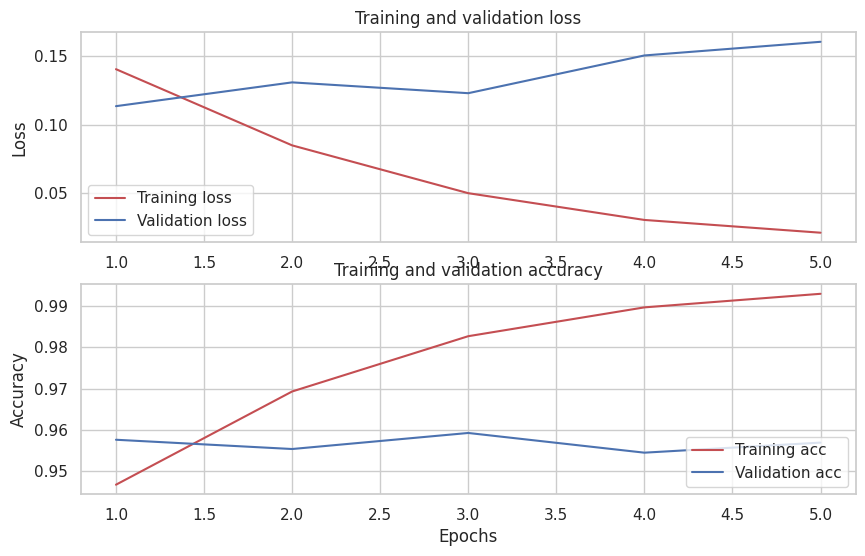

In [78]:
history2_dict = history2.history
print(history2_dict.keys())

acc2 = history2_dict['accuracy']
val_acc2 = history2_dict['val_accuracy']
loss2 = history2_dict['loss']
val_loss2 = history2_dict['val_loss']

epochs2 = range(1, len(acc2) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs2, loss2, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs2, val_loss2, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs2, acc2, 'r', label='Training acc')
plt.plot(epochs2, val_acc2, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [110]:
text2 = ["Today I felt good in the morning, everything was good, but in the evening, it rained, and as a result, I got stuck in traffic. My life sucks; I should end it; I should kill myself.",
        "Today, I felt good in the morning; everything was good, but in the evening, it rained, and as a result, I got stuck in traffic. My life sucks."]

input_ids3 = []
attention_masks3 = []

for t in text2:
    bert_inp3 = bert_tokenizer.encode_plus(t, add_special_tokens=True, max_length=64, pad_to_max_length=True, return_attention_mask=True)
    input_ids3.append(bert_inp3['input_ids'])
    attention_masks3.append(bert_inp3['attention_mask'])

input_ids3 = np.asarray(input_ids3)
attention_masks3 = np.asarray(attention_masks3)

text_data2 = [(input_ids3, attention_masks3)]

predictions2 = trained_model2.predict(text_data2)

1/1 [==============================] - 0s 132ms/step


In [111]:
predictions2

TFSequenceClassifierOutput(loss=None, logits=array([[-0.81550825,  1.2490038 ],
       [ 1.058196  , -0.09424316]], dtype=float32), hidden_states=None, attentions=None)

In [112]:
logits2 = predictions.logits
probas2 = np.exp(logits) / np.sum(np.exp(logits2), axis=1, keepdims=True)
preditions_labels2 = np.argmax(probas2, axis=-1)
preditions_labels2

array([1, 0])

#### Reference
- Classify text with BERT: https://www.tensorflow.org/text/tutorials/classify_text_with_bert
- NLP for Suicide and Depression Identification with Noisy Labels: https://towardsdatascience.com/nlp-for-suicide-and-depression-identification-with-noisy-labels-98d7bb98f3e8
- Open Sourcing BERT: State-of-the-Art Pre-training for Natural Language Processing: https://ai.googleblog.com/2018/11/open-sourcing-bert-state-of-art-pre.html
- Spam Email Classification using BERT: https://www.kaggle.com/code/kshitij192/spam-email-classification-using-bert
- BERT Text Classification using Keras: https://swatimeena989.medium.com/bert-text-classification-using-keras-903671e0207d
- BERT: https://huggingface.co/docs/transformers/model_doc/bert

